In [1]:
%matplotlib notebook

import tensorflow as tf
from tensorflow.keras import backend as K

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

import seaborn as sns
from scipy import stats
import os
from sklearn.metrics import r2_score, mean_absolute_error
from joblib import load

import sys
sys.path.insert(0,'..')
from models import get_model1


mpl.rc('font', **{'family':'sans-serif', 'sans-serif':['DejaVu Sans']})
mpl.rc('text', usetex = True)


K.clear_session()
sns.set()

tf.__version__

'2.8.0'

## Import and preprocess data

* Note the z-score method is used for removing outliers with a threshold of 3
* A number of redundant features are drop

In [2]:
w1 = pd.read_csv('../data/well1.csv')
w2 = pd.read_csv('../data/well2.csv')

def _remove_outlier_z(data, th=3):
    
    s1 = data.shape
    z_score = np.abs(stats.zscore(data))
    idx = np.where(z_score>th)
    data = data.drop(idx[0], axis=0)
    data = data[data>0].dropna()
    data = data.reset_index().drop(['index'], axis=1)
    data = data.sort_values(by=['Hole Depth'], ascending=True)
    s2 = data.shape
    print(f'Shape before removing outliser {s1} \t\t shape after removing the outliers {s2}')
    
    return data        

w1 = _remove_outlier_z(w1, th=3)
w2 = _remove_outlier_z(w2, th=3)

Shape before removing outliser (7999, 21) 		 shape after removing the outliers (7437, 21)
Shape before removing outliser (9091, 21) 		 shape after removing the outliers (8154, 21)


In [3]:
drop = ['Standpipe Pressure', 'Bit Depth', 'Bit RPM', 'Min RPM', 'Min Hook Load', 'Min Pressure', 
       'Line Wear', 'Block Height', 'Time Of Penetration', 'Min WOB']

w1 = w1.drop(drop, axis=1)
w2 = w2.drop(drop, axis=1)

In [4]:
w1.head()

,Hole Depth,Rotary Torque,Rotary RPM,Weight on Bit,Hook Load,Differential Pressure,Inclination,Total Mud Volume,Gamma at Bit,Min Torque,Rate Of Penetration
0,6835,6.690,40,15.4,143.4,400.1,23.7,420.7,117.65,3.0,78.44
1,6836,5.791,32,14.7,138.2,400.5,23.7,415.5,120.00,4.0,75.28
2,6837,5.166,30,12.7,138.7,347.9,23.7,412.0,122.35,4.0,48.82
3,6838,4.922,30,12.2,139.2,345.5,23.7,410.3,122.35,4.0,48.92
4,6839,4.810,30,11.5,139.6,338.2,23.7,408.9,122.35,4.0,48.73


### Load model and create input data
* Note the scaler object was fitted on the original training data and should be used for correct transformation of the data
* The model must be built and compiled and then weights can be loaded

In [5]:
X1 = w1.drop(['Rate Of Penetration'], axis=1).to_numpy()
y1 = w1['Rate Of Penetration'].to_numpy()


X2 = w2.drop(['Rate Of Penetration'], axis=1).to_numpy()
y2 = w2['Rate Of Penetration'].to_numpy()

In [6]:
scaler = load('scaler_obj.joblib')

X1 = scaler.transform(X1)
X2 = scaler.transform(X2)

In [9]:
model = get_model1(input_shape=(X1.shape[1], ))
model.load_weights('../weights/model1.h5')
print('Model loaded')

Model loaded


In [7]:
rf_reg = load('../weights/random_forest.joblib')
xgb_reg = load('../weights/xgb_reg.joblib')

C:\Users\m_biz\anaconda3\envs\dl\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Make prediction
* 1 and 2 refer to well 1 and well 2 data 
* R$^{2}$ and mean absolute error are computed in the second cell

In [10]:
y_pred_nn_1 = model(X1, training=False).numpy()
y_pred_nn_2 = model(X2, training=False).numpy()

y_pred_rf_1 = rf_reg.predict(X1)
y_pred_rf_2 = rf_reg.predict(X2)

y_pred_xgb_1 = xgb_reg.predict(X1)
y_pred_xgb_2 = xgb_reg.predict(X2)

In [55]:
R2_nn_1 = r2_score(y1, y_pred_nn_1)
R2_nn_2 = r2_score(y2, y_pred_nn_2)

MAE_nn_1 = mean_absolute_error(y1, y_pred_nn_1)
MAE_nn_2 = mean_absolute_error(y2, y_pred_nn_2)

R2_rfg_1 = r2_score(y1, y_pred_rf_1)
R2_rgf_2 = r2_score(y2, y_pred_rf_2)

MAE_rfg_1 = mean_absolute_error(y1, y_pred_rf_1)
MAE_rfg_2 = mean_absolute_error(y2, y_pred_rf_2)

R2_xgb_1 = r2_score(y1, y_pred_xgb_1)
R2_xgb_2 = r2_score(y2, y_pred_xgb_2)

MAE_xgb_1 = mean_absolute_error(y1, y_pred_xgb_1)
MAE_xgb_2 = mean_absolute_error(y2, y_pred_xgb_2)

<IPython.core.display.Javascript object>


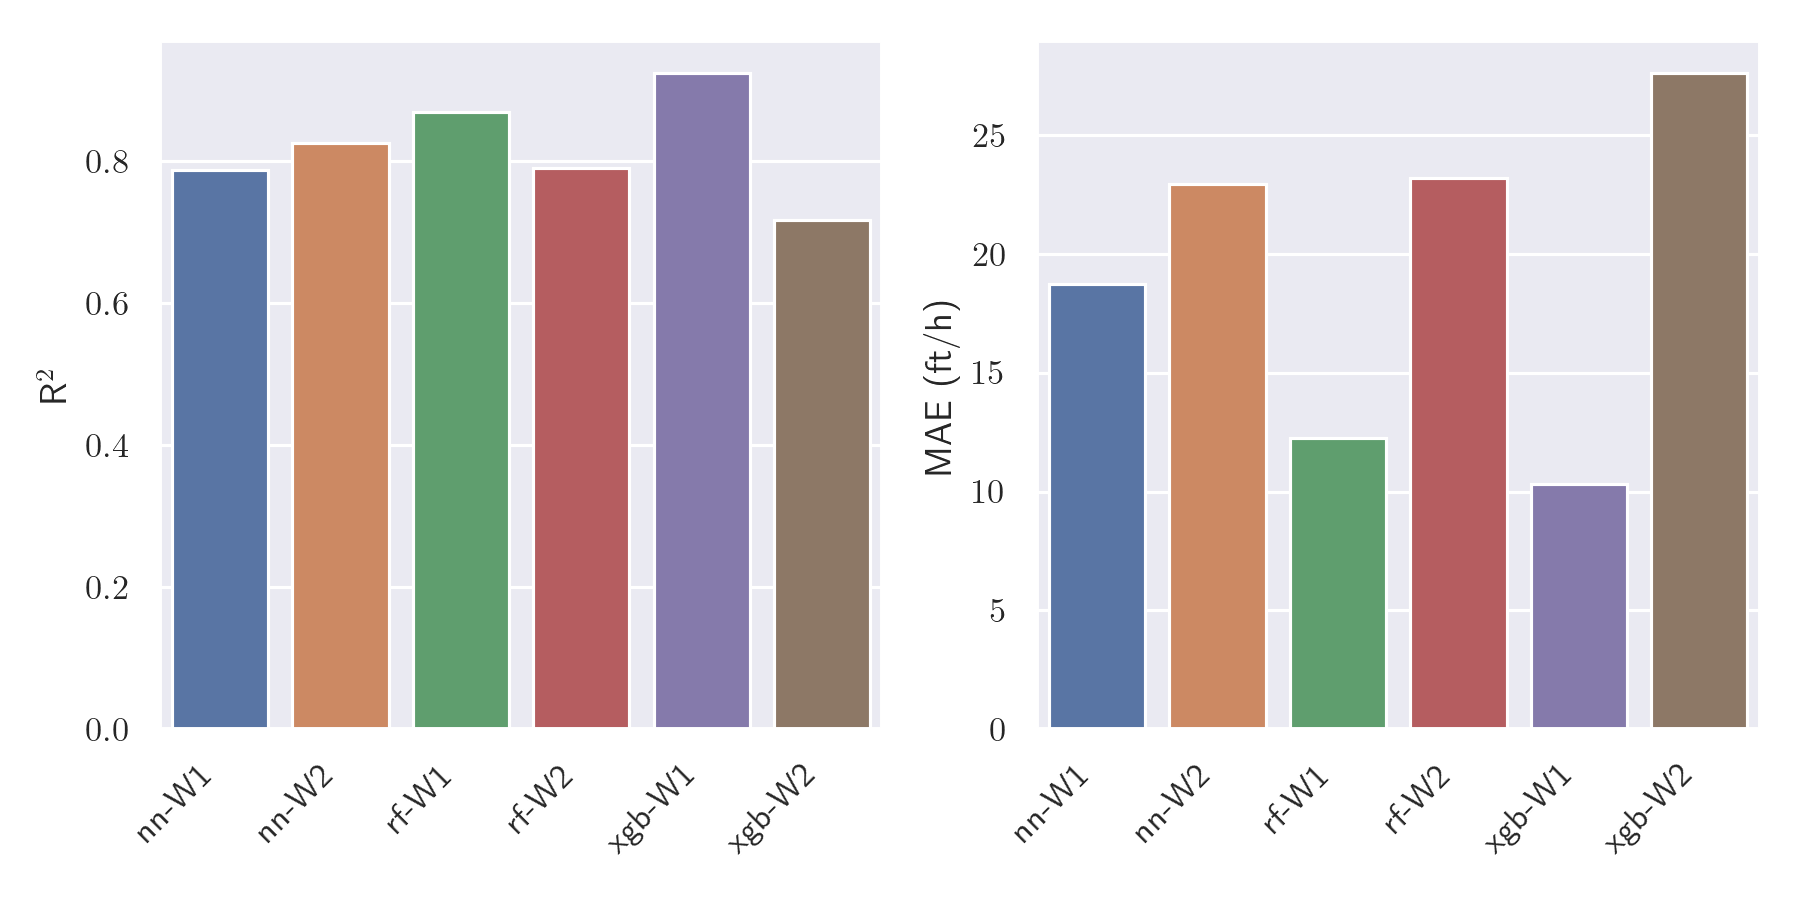

In [57]:
r2 = [R2_nn_1, R2_nn_2, R2_rfg_1, R2_rgf_2, R2_xgb_1, R2_xgb_2]
mae = [MAE_nn_1, MAE_nn_2, MAE_rfg_1, MAE_rfg_2, MAE_xgb_1, MAE_xgb_2]

r2 = pd.DataFrame(r2, index=['nn-W1', 'nn-W2', 'rf-W1', 'rf-W2', 'xgb-W1', 'xgb-W2']).rename({0:'R2'}, axis=1)
mae = pd.DataFrame(mae, index=['nn-W1', 'nn-W2', 'rf-W1', 'rf-W2', 'xgb-W1', 'xgb-W2']).rename({0:'mae'}, axis=1)

fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(8,4))
sns.barplot(data=r2,x=r2.index,y='R2', ax=ax[0])
sns.barplot(data=mae,x=mae.index,y='mae', ax=ax[1])

for label in ax[0].get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)

for label in ax[1].get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)


ax[0].set_ylabel(r'R$^{2}$')
ax[1].set_ylabel('MAE (ft/h)')

plt.tight_layout()
plt.show()

## Plots
* First plot is a scatter plot of predicted ROPs vs true ROP values with R$^{2}$ and MAE reported in the title of each plot
* Second and third plots are ROP vs depth plots for well 1 and well 2

<IPython.core.display.Javascript object>


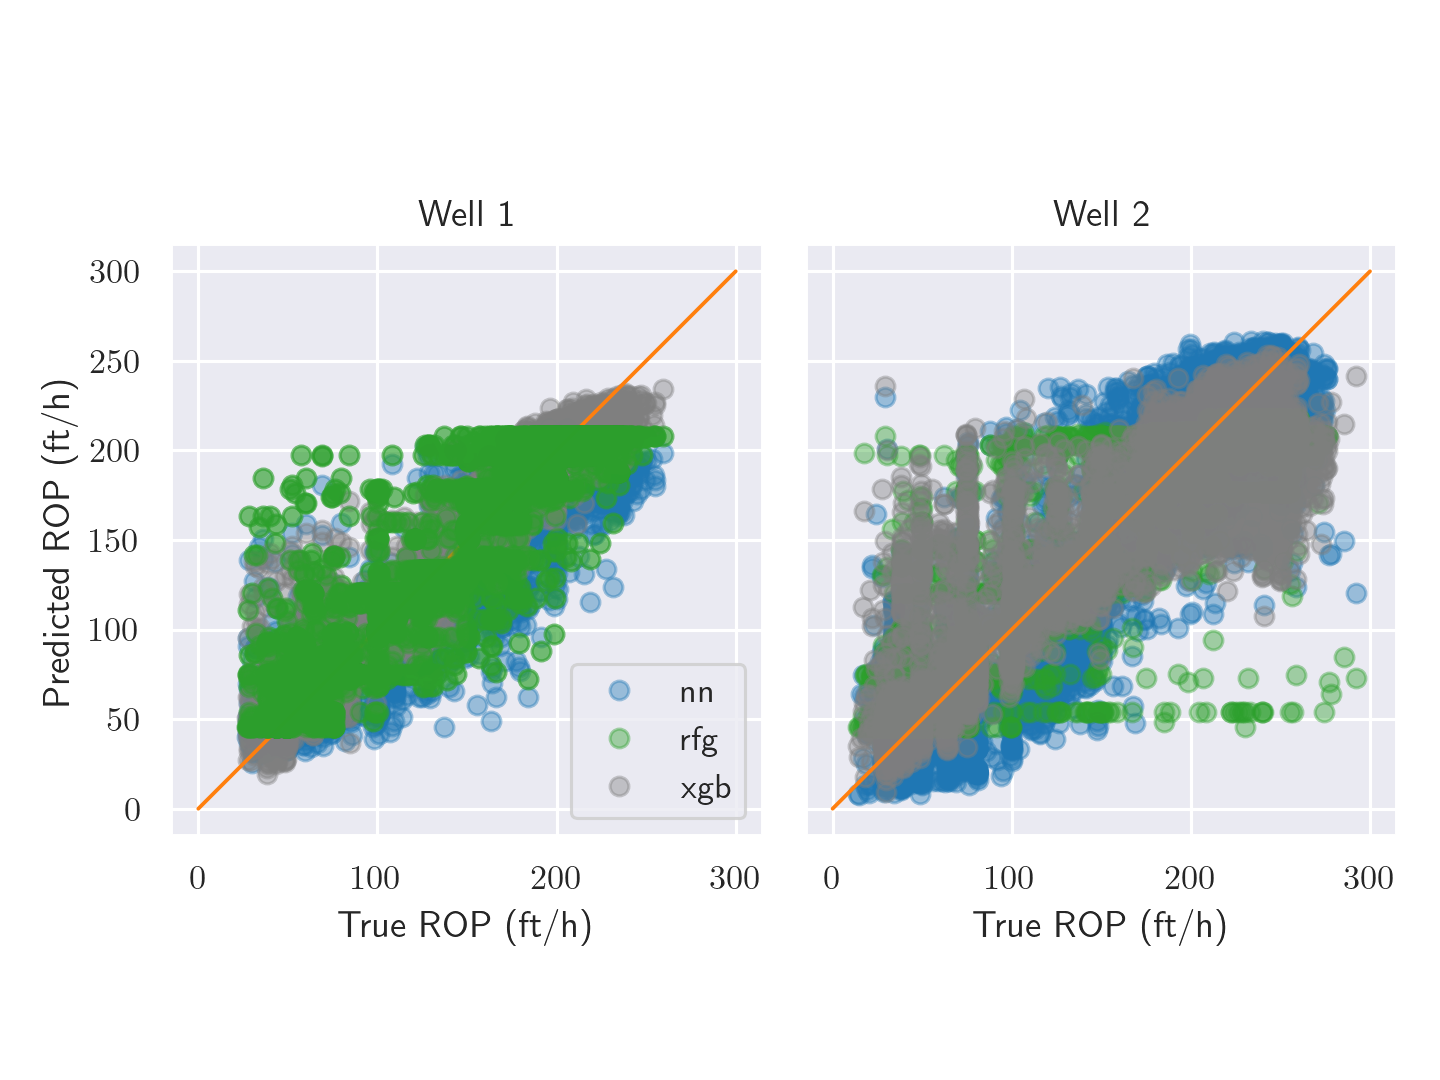

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=120)

ax[0].plot(y1, y_pred_nn_1, 'o', alpha=0.4, color='tab:blue', label='nn')
ax[0].plot(y1, y_pred_rf_1, 'o', alpha=0.4, color='tab:green', label='rfg')
ax[0].plot(y1, y_pred_xgb_1, 'o', alpha=0.4, color='tab:gray', label='xgb')

ax[0].plot([0,300], [0,300], '-', linewidth=1.2, color='tab:orange')

ax[0].plot(y1, y_pred_rf_1, 'o', alpha=0.4, color='tab:green')


ax[1].plot(y2, y_pred_nn_2, 'o', alpha=0.4, color='tab:blue', label='nn')
ax[1].plot(y2, y_pred_rf_2, 'o', alpha=0.4, color='tab:green', label='rfg')
ax[1].plot(y2, y_pred_xgb_2, 'o', alpha=0.4, color='tab:gray', label='xgb')

ax[1].plot([0,300], [0,300], '-', linewidth=1.2, color='tab:orange')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].set_xlabel('True ROP (ft/h)')
ax[1].set_xlabel('True ROP (ft/h)')
ax[0].set_ylabel('Predicted ROP (ft/h)')

ax[0].set_title('Well 1')
ax[1].set_title('Well 2')

ax[0].legend(frameon=True, loc='lower right')
# ax[1].legend(frameon=False, loc='upper left', ncol=3)

plt.tight_layout()
plt.show()

In [69]:
alpha=0.9
max_md = w2['Hole Depth'].max()
min_md = 9000

def _plot_rop_depth(depth,rop_true, rop_nn,rop_rfg, rop_xgb , test=True):
    
        """
        depth is the measured depth to plot the ROP values against 
        rop_true is the array of true ROP values
        rop_pred is the array of predicted ROPs
        test is a boolean indicating whether the test data was part of this well or not 
        (use True for well 2 to plot the test section)
        """
    
        _, ax = plt.subplots(dpi=120, figsize=(14, 4), nrows=2)

        ax[0].plot(depth, rop_true, '-', alpha=0.75, linewidth=1,  
                        color='tab:blue', label='True ROP')
        
        ax[0].plot(depth, rop_nn, '-', alpha=0.75, linewidth=1,  
                        color='tab:orange', label='ROP - Neural network')
        
        ax[0].plot(depth, rop_rfg, '-', alpha=0.75, linewidth=1,  
                    color='tab:green', label='ROP - Random Forest')

        ax[0].plot(depth, rop_xgb, '-', alpha=0.75, linewidth=1,  
                color='tab:red', label='ROP - XGBoost')

        ax[0].set_xlabel('Measured Depth (ft)', alpha=alpha, fontsize=12)
        ax[0].set_ylabel('ROP (ft/h)', alpha=alpha, fontsize=12)
        
        l = ax[0].legend(frameon=False, loc='upper left', fontsize=12, ncol=4)
        for text in l.get_texts():
                text.set_alpha(alpha)

        ax[0].tick_params(labelsize=12)
        

        for text in ax[1].get_xticklabels():
                text.set_alpha(alpha)
                
        for text in ax[1].get_yticklabels():
                text.set_alpha(alpha)

        for t in ax[1].xaxis.get_ticklines():
                t.set_alpha(alpha)

        for t in ax[1].yaxis.get_ticklines():
                t.set_alpha(alpha)
                
        for spine in ['top', 'bottom', 'right', 'left']:
                ax[0].spines[spine].set_alpha(alpha)
                ax[0].spines[spine].set_linewidth(1)
                ax[1].spines[spine].set_alpha(alpha)
                ax[1].spines[spine].set_linewidth(1)

        ax[1].plot(depth, rop_true, '-', alpha=0.75, linewidth=1,  
                        color='tab:blue', label='True ROP')
        
        ax[1].plot(depth, rop_nn, '-', alpha=0.75, linewidth=1,  
                        color='tab:orange', label='ROP - Neural network')
        
        ax[1].plot(depth, rop_rfg, '-', alpha=0.75, linewidth=1,  
                    color='tab:green', label='ROP - Random Forest')

        ax[1].plot(depth, rop_xgb, '-', alpha=0.75, linewidth=1,  
                color='tab:red', label='ROP - XGBoost')
        
        # ax.invert_yaxis()
        if test:
                rect = Rectangle((min_md, 25), max_md-min_md, 260, linewidth=1.2, edgecolor='tab:gray', 
                        facecolor='none', alpha=alpha, linestyle='--')
                ax[0].add_patch(rect)
                ax[1].set_xlim([min_md, max_md])
                
                ax[0].annotate('Test section', xy=(max_md-1500, 300),  xycoords='data',
                        xytext=(0.87, 0.925), textcoords='axes fraction', fontsize=12,
                        horizontalalignment='right', verticalalignment='top')
                
                ax[1].annotate('Test section', xy=(max_md-1500, 300),  xycoords='data',
                        xytext=(0.1, 0.925), textcoords='axes fraction', fontsize=12,
                        horizontalalignment='right', verticalalignment='top')

                ax[0].set_ylim([0,400])
                ax[1].set_ylim([0,400])

        elif not test:
                rect = Rectangle((8500, 25), 3000, 260, linewidth=1.2, edgecolor='tab:gray', 
                        facecolor='none', alpha=alpha, linestyle='--')
                ax[0].add_patch(rect)
                ax[1].set_xlim([8500, 11500])
                ax[0].set_ylim([0,400])
                ax[1].set_ylim([0,300])

        ax[1].tick_params(labelsize=12)
        
        ax[1].set_xlabel('Measured Depth (ft)', alpha=alpha, fontsize=12)
        ax[1].set_ylabel('ROP (ft/h)', alpha=alpha, fontsize=12)

        plt.tight_layout()
        
        plt.show()


<IPython.core.display.Javascript object>


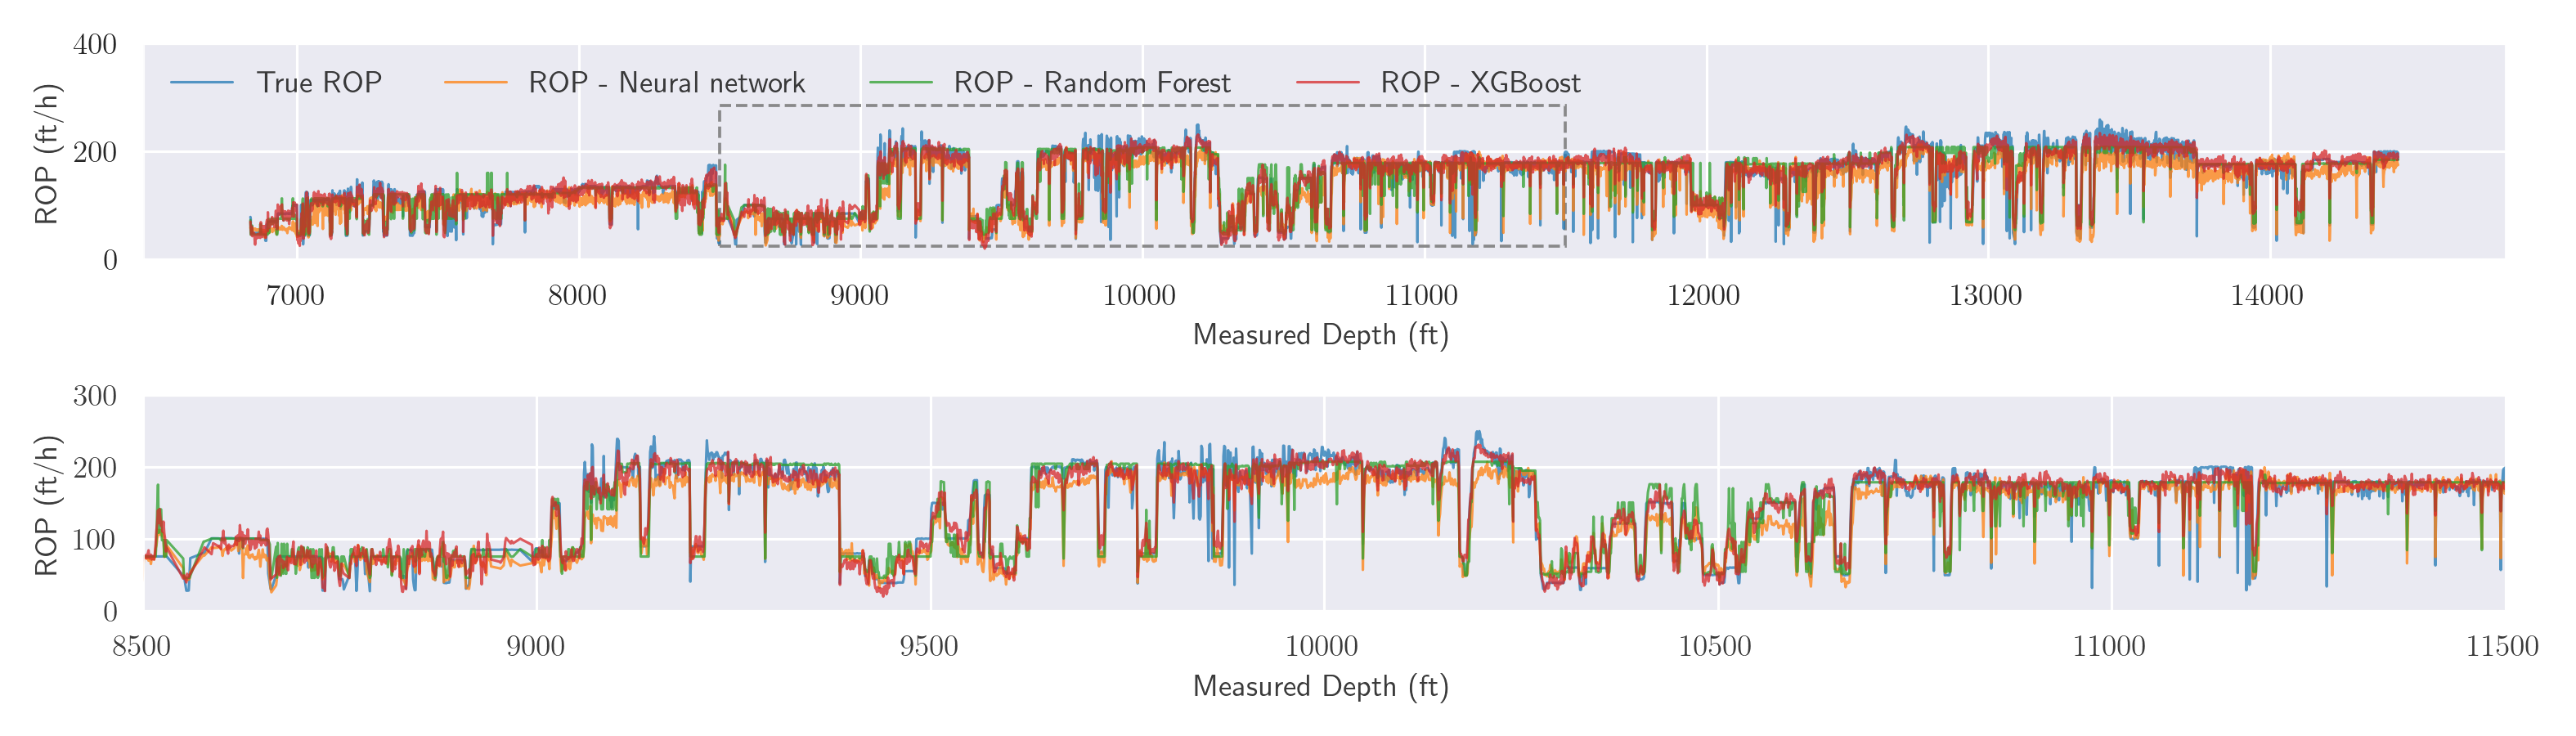

In [70]:
_plot_rop_depth(depth=w1['Hole Depth'], 
                rop_true=w1['Rate Of Penetration'], 
                rop_nn=y_pred_nn_1, 
                rop_rfg=y_pred_rf_1, 
                rop_xgb=y_pred_xgb_1, 
                test=False)

<IPython.core.display.Javascript object>


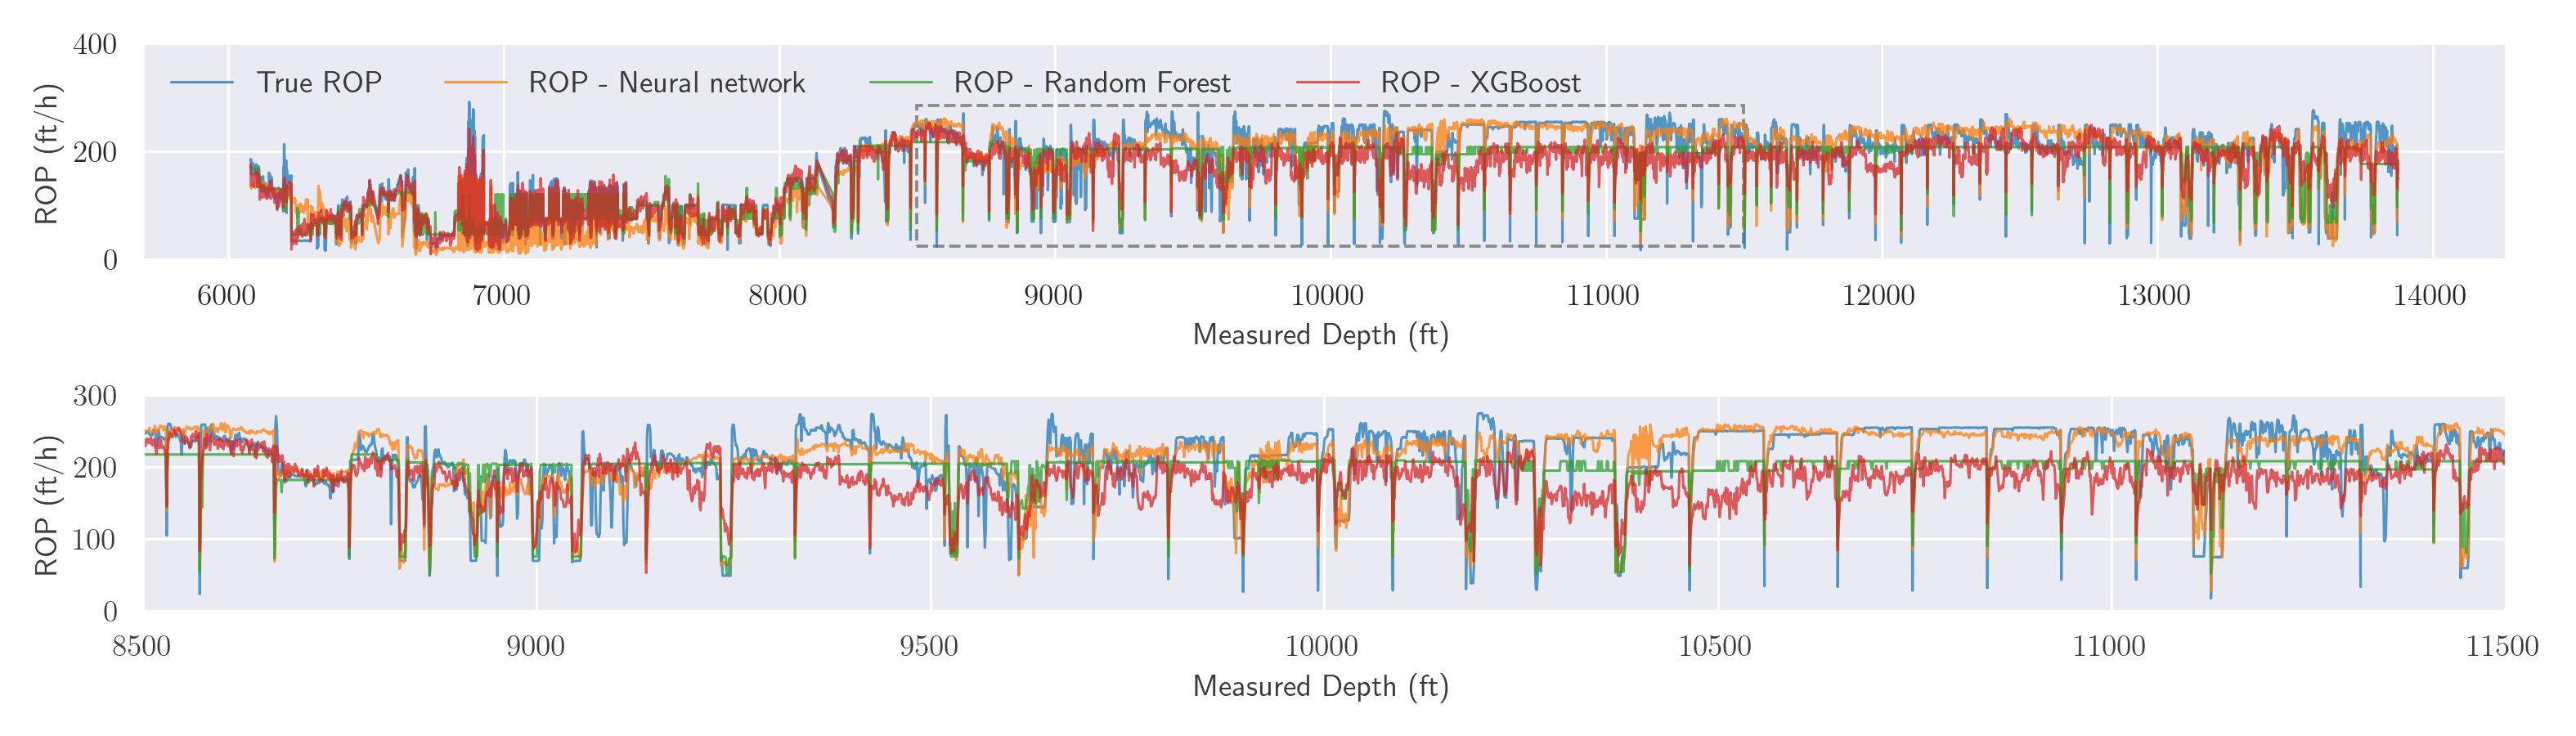

In [71]:
_plot_rop_depth(depth=w2['Hole Depth'], 
                rop_true=w2['Rate Of Penetration'], 
                rop_nn=y_pred_nn_2, 
                rop_rfg=y_pred_rf_2, 
                rop_xgb=y_pred_xgb_2, 
                test=False)

## Absolute difference boxplot

In [73]:
ad_nn_1 = np.abs(w1['Rate Of Penetration'].values - y_pred_nn_1.flatten())
ad_nn_2 = np.abs(w2['Rate Of Penetration'].values - y_pred_nn_2.flatten())

ad_rf_1 = np.abs(w1['Rate Of Penetration'].values - y_pred_rf_1.flatten())
ad_rf_2 = np.abs(w2['Rate Of Penetration'].values - y_pred_rf_2.flatten())

ad_xgb_1 = np.abs(w1['Rate Of Penetration'].values - y_pred_xgb_1.flatten())
ad_xgb_2 = np.abs(w2['Rate Of Penetration'].values - y_pred_xgb_2.flatten())

In [74]:
def _boxplot(x, ax, label, pos = [1], c1='tab:blue', c2 = 'tab:orange'):
        return ax.boxplot(x, labels=[label], 
                        positions = pos, showfliers=True,
                        patch_artist=True,
                        boxprops=dict(facecolor='w', 
                        color=c1, alpha=1),
                        capprops=dict(color=c1),
                        whiskerprops=dict(color=c1),
                        flierprops=dict(color=c1, markeredgecolor=c1, markersize=1.5),
                        medianprops=dict(color=c2, linewidth=1))


<IPython.core.display.Javascript object>


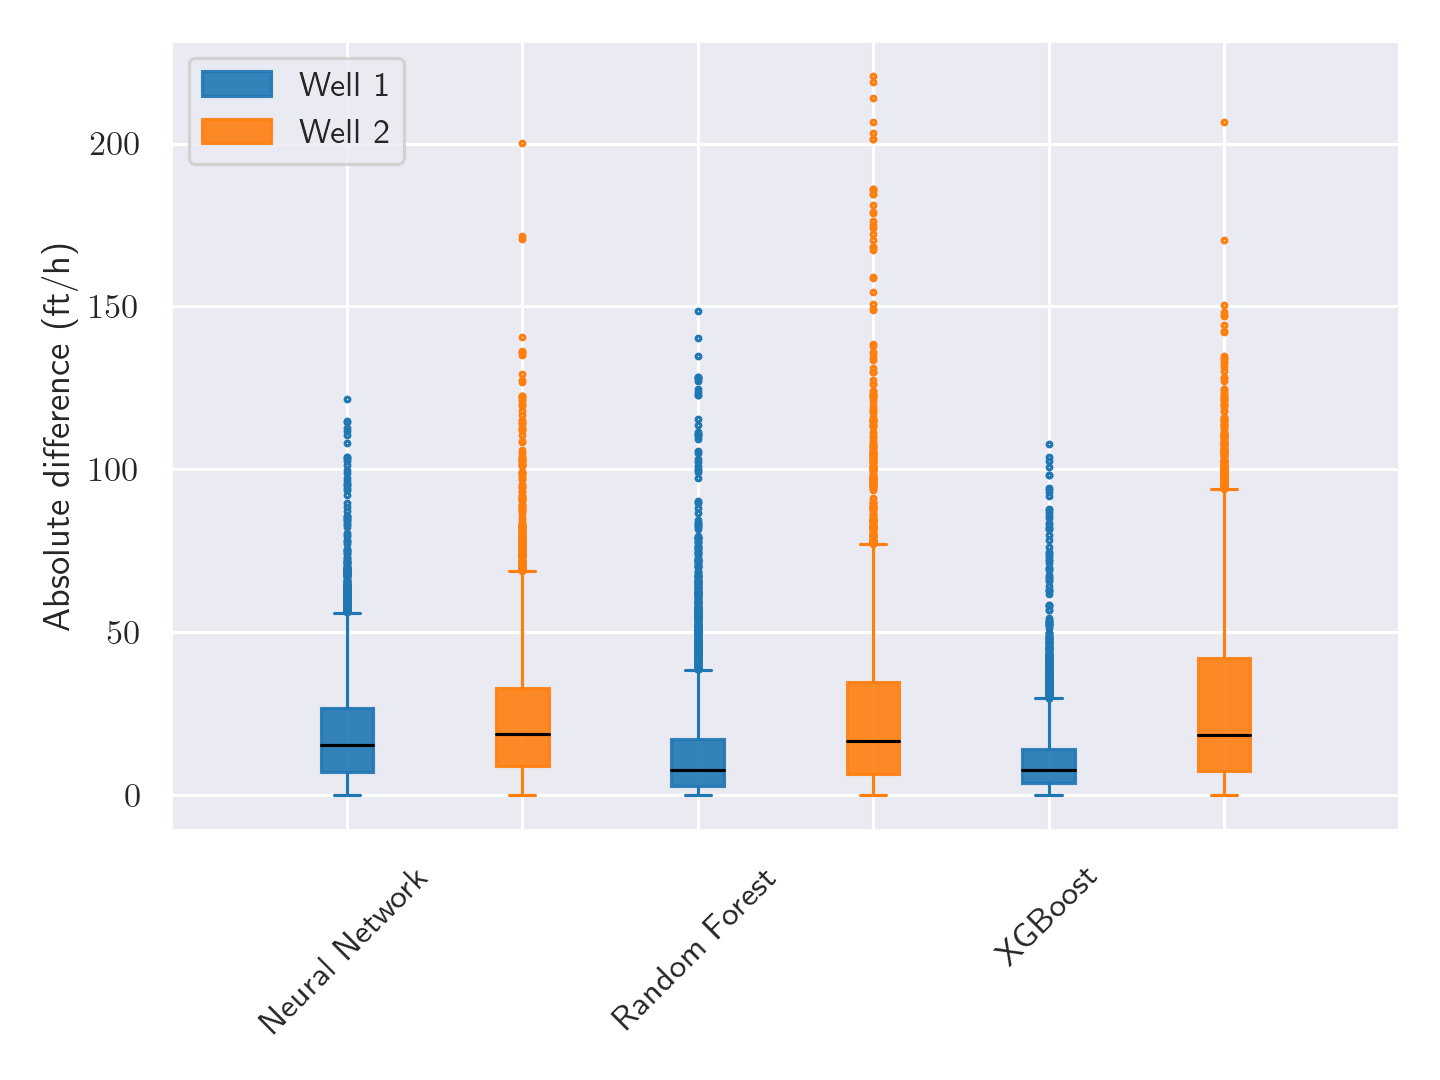

In [77]:
fig, ax = plt.subplots(dpi=120)
# ax2 = ax.twiny()

B1 = _boxplot(ad_nn_1, ax, label = 'Neural Network', pos=[1], c1='tab:blue', c2 = 'black')
B2 = _boxplot(ad_nn_2, ax, label = '', pos=[1.5], c1='tab:orange', c2 = 'black')

B3 = _boxplot(ad_rf_1, ax, label = 'Random Forest', pos=[2], c1='tab:blue', c2 = 'black')
B4 = _boxplot(ad_rf_2, ax, label = '', pos=[2.5], c1='tab:orange', c2 = 'black')

B5 = _boxplot(ad_xgb_1, ax, label = 'XGBoost', pos=[3], c1='tab:blue', c2 = 'black')
B6 = _boxplot(ad_xgb_2, ax, label = '', pos=[3.5], c1='tab:orange', c2 = 'black')


for b1, b2 in zip(B1['boxes'], B2['boxes']):
        # box.set_hatch('////////')
        b1.set_facecolor('tab:blue')
        b2.set_facecolor('tab:orange')
        b1.set_alpha(0.9)
        b2.set_alpha(0.9)
        
for b1, b2 in zip(B3['boxes'], B4['boxes']):
        # box.set_hatch('////////')
        b1.set_facecolor('tab:blue')
        b2.set_facecolor('tab:orange')
        b1.set_alpha(0.9)
        b2.set_alpha(0.9)

for b1, b2 in zip(B5['boxes'], B6['boxes']):
        # box.set_hatch('////////')
        b1.set_facecolor('tab:blue')
        b2.set_facecolor('tab:orange')
        b1.set_alpha(0.9)
        b2.set_alpha(0.9)

ax.set_ylabel('Absolute difference (ft/h)')

for label in ax.get_xticklabels():
        label.set_ha("center")
        label.set_rotation(45)

ax.tick_params(axis='x', which='minor', bottom=False, top = False)
ax.tick_params(axis='x', which='major', bottom=False, top = False)

ax.legend([B1["boxes"][0], B2["boxes"][0]],
        ['Well 1', 'Well 2'], loc='upper left')

plt.tight_layout()
plt.show()
